In [26]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)


# https://github.com/openai/gym/blob/master/gym/core.py
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

        

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

DDPG uses four neural networks: a Q network, a deterministic policy network, a target Q network, and a target policy network.







The Q network and policy network is very much like simple Advantage Actor-Critic, but in DDPG, the Actor directly maps states to actions (the output of the network directly the output) instead of outputting the probability distribution across a discrete action space.

The target networks are time-delayed copies of their original networks that slowly track the learned networks. Using these target value networks greatly improve stability in learning. 

Let's create these networks.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x

Now, let's create the DDPG agent. The agent class has two main functions: "get_action" and "update":



*   **get_action()**: This function runs a forward pass through the actor network to select a determinisitic action. In the DDPG paper, the authors use Ornstein-Uhlenbeck Process to add noise to the action output (Uhlenbeck & Ornstein, 1930), thereby resulting in exploration in the environment. Class OUNoise (in cell 1) implements this.






*   **update()**: This function is used for updating the actor and critic networks, and forms the core of the DDPG algorithm. The replay buffer is first sampled to get a batch of experiences of the form **<states, actions, rewards, next_states>**. 

The value network is updated similarly as is done in Q-learning. The updated Q value is obtained by the Bellman equation. However, in DDPG, the next-state Q values are calculated with the target value network and target policy network. Then, we minimize the mean-squared loss between the updated Q value and the original Q value:



For the policy function, our objective is to maximize the expected return. To calculate the policy loss, we take the derivative of the objective function with respect to the policy parameter. Keep in mind that the actor (policy) function is differentiable, so we have to apply the chain rule. 

But since we are updating the policy in an off-policy way with batches of experience, we take the mean of the sum of gradients calculated from the mini-batch:



We make a copy of the target network parameters and have them slowly track those of the learned networks via “soft updates,” as illustrated below:








In [28]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn
#from model import *
#from utils import *

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=1e-2, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Implement critic loss        
        next_q = self.critic_target.forward(next_states, self.actor_target.forward(next_states).detach())
        critic_loss = self.critic_criterion(self.critic.forward(states, actions), rewards + self.gamma * next_q)

        # Implement actor loss
        ac_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # Update actor and critic networks
        self.actor_optimizer.zero_grad()
        ac_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

Putting it all together: DDPG in action.

The main function below runs 100 episodes of DDPG on the "Pendulum-v0" environment of OpenAI gym. This is the inverted pendulum swingup problem, a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. 

Each episode is for a maximum of 500 timesteps. At each step, the agent chooses an action, updates its parameters according to the DDPG algorithm and moves to the next state, repeating this process till the end of the episode.

The DDPG algorithm is as follows:



episode: 0, reward: -1126.55, average _reward: -1126.5543988424454 
episode: 1, reward: -1556.53, average _reward: -1341.5430901076447 
episode: 2, reward: -1579.91, average _reward: -1420.9982149297928 
episode: 3, reward: -1261.35, average _reward: -1381.0859601226994 
episode: 4, reward: -1336.44, average _reward: -1372.1569084765301 
episode: 5, reward: -1012.89, average _reward: -1312.2784060779152 
episode: 6, reward: -981.1, average _reward: -1264.9668087756236 
episode: 7, reward: -753.39, average _reward: -1201.019431292632 
episode: 8, reward: -892.55, average _reward: -1166.7448898892824 
episode: 9, reward: -714.94, average _reward: -1121.5640237384466 
episode: 10, reward: -512.37, average _reward: -1060.1457386273482 
episode: 11, reward: -261.92, average _reward: -930.6841539620642 
episode: 12, reward: -255.89, average _reward: -798.2824157457655 
episode: 13, reward: -383.53, average _reward: -710.5000186615852 
episode: 14, reward: -495.06, average _reward: -626.36199

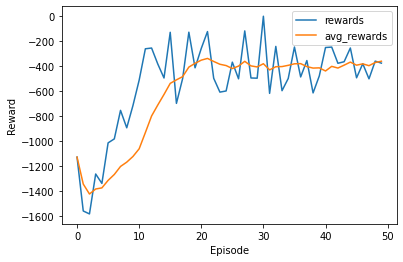

In [30]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = NormalizedEnv(gym.make("Pendulum-v0"))

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 128
rewards = []
avg_rewards = []

for episode in range(50):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(500):
        action = agent.get_action(state)
        #Add noise to action
        
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward

        ind = -10
        if episode<=9:
          ind = 0

        if done:
            if episode>0:
              rew = rewards[ind:]
              rew.append(episode_reward)
              sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2), np.mean(rew[ind:])))
            else:
              sys.stdout.write("episode: {}, reward: {}, average _reward: {} \n".format(episode, np.round(episode_reward, decimals=2),episode_reward))
            break

    rewards.append(episode_reward)
    if episode>=9:
      avg_rewards.append(np.mean(rewards[-10:]))
    else:
      avg_rewards.append(np.mean(rewards[:]))

plt.plot(rewards,label='rewards')
plt.plot(avg_rewards,label='avg_rewards')
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

[1, 2, 3, 4]